<a href="https://colab.research.google.com/github/Erfaan-Rostami/Machine-Learning/blob/master/Training%20Linear%20Models%20-%20Hands%20on%20Machine%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning Tutorial** , Ordibehesht 2, 18:00 via LMS [Class Room](http://vc26.sbu.ac.ir/class-2216137-91), AML Course Recitation, **Session Eight**

[Applied Machine Learning](https://github.com/hhaji/Applied-Machine-Learning), Data Science Center, Shahid Beheshti University

Modified by [Erfaan Rostami Amraei](https://github.com/Erfaan-Rostami)



**Acknowledgment:**



The code is modified based on:
* [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow (2nd Edition)](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) by Aurelien Geron   

   - **Chapter 4 – Training Models** 



<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1S1RguKRlxG3jE7z1lelIX0Uk3pImr05m#scrollTo=spzv7iNtrl9b"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

##Chapter 4 – Training Models##
In this chapter, we will start by looking at the **Linear Regression model**, one of the
simplest models there is. We will discuss two very different ways to train it:
- Using a direct “**closed-form**” equation that directly computes the model parame‐
ters that best fit the model to the training set.
- Using an iterative optimization approach, called **Gradient Descent** (GD). We will look at a few variants of Gradient Descent that we will use again
and again when we study neural networks in Part II: Batch GD, Mini-batch GD,
and Stochastic GD.

# Setup

First, let's **import** a few **common modules**, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Linear regression using the Normal Equation

In [0]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure generated_data_plot


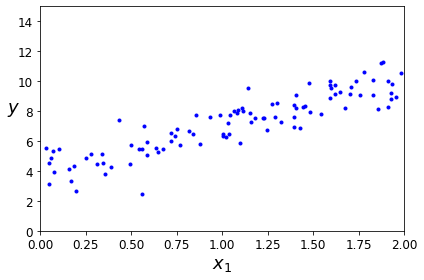

In [5]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [0]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [7]:
theta_best

array([[3.86501051],
       [3.13916179]])

In [8]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.86501051],
       [10.14333409]])

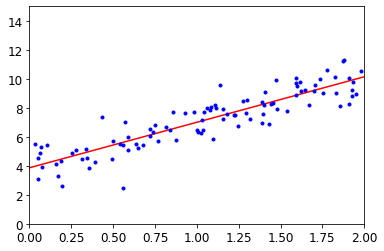

In [9]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

The figure in the book actually corresponds to the following code, with a legend and axis labels:

Saving figure linear_model_predictions_plot


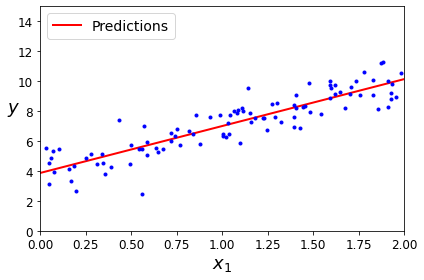

In [10]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

In [11]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.86501051]), array([[3.13916179]]))

In [12]:
lin_reg.predict(X_new)

array([[ 3.86501051],
       [10.14333409]])

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares"), which you could call directly:

In [13]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.86501051],
       [3.13916179]])

This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the _pseudoinverse_ of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [14]:
np.linalg.pinv(X_b).dot(y)

array([[3.86501051],
       [3.13916179]])

# Linear regression using batch gradient descent

In [0]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [16]:
theta

array([[3.86501051],
       [3.13916179]])

In [17]:
X_new_b.dot(theta)

array([[ 3.86501051],
       [10.14333409]])

In [0]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

Saving figure gradient_descent_plot


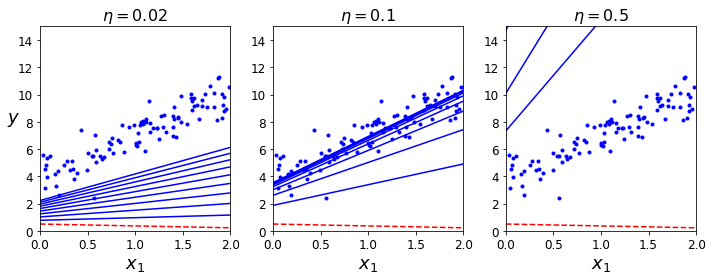

In [20]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

# Stochastic Gradient Descent

In [0]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

Saving figure sgd_plot


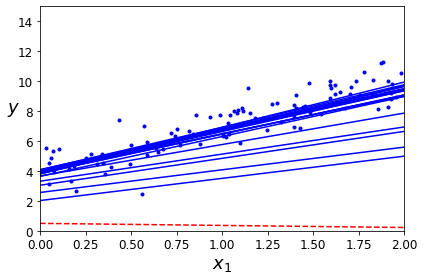

In [22]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
save_fig("sgd_plot")                                 # not shown
plt.show()                                           # not shown

In [23]:
theta

array([[3.90521218],
       [3.15642095]])

In [24]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [25]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.86256592]), array([3.15101583]))

# Mini-batch gradient descent

In [0]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [27]:
theta

array([[3.87558894],
       [3.13893713]])

In [0]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure gradient_descent_paths_plot


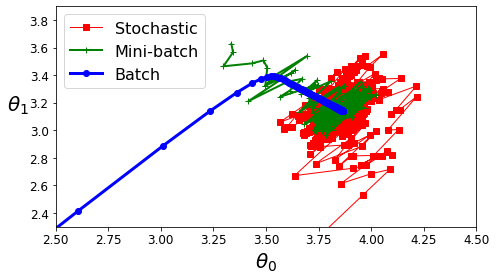

In [29]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

# Training Model Questions



##### The following questions go over the knowledge of ML Training Models (Linear Regression, Logistic Regression). They are from the end of Chapter 4 of Aurelien Geron's *Hands-On Machine Learning with Scikit-Learn & TensorFlow*. 



1. What Linear Regression training algorithm can you use if you have a training set with millions of features?

   *Since there are lots of features, we cannot use Normal Equations (it will be very, very computationally expensive). Instead we can use Gradient Descent.*

2. Suppose the features in your training set have very different scales. What algorithms might suffer from this, and how? What can you do about it?

   *The Gradient Descent suffers from features of different scales, because the model will take a longer time to reach the global maximum. We can always scale the features to eliminate this problem.*

3. Can Gradient Descent get stuck in a local minimum when training a Logistic Regression model?

   *Since Logistic Regression Model cost function is convex, there is no local minimum.*

4. Do all Gradient Descent algorithms lead to the same model provided you let them run long enough?

   *No. If the learning rate is too high, then the model can diverge. It can also only reach the local minimum based on where the initialization is.*

5. Suppose you use Batch Gradient Descent and you plot the validation error at every epoch. If you notice that the validation error consistently goes up, what is likely going on? How can you fix this?

   *If the validation error consistently goes up, that means the model could be diverging because of high learning rate. If the training error also goes up, that is the indication of diverging. You can fix that by lowering the learning rate and then re-training. If the training error is **not** increasing, then your model is overfitting and you have to retrain with a different model.*

6. Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?

   *No, because it will be erratic in approaching the minimum (just like Stochastic Gradient Descent, but to less degree). You can always revert to the best case if the error does not improve for a while.*

7. Which Gradient Descent Algorithm will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?

   *The Stochastic Gradient Descent will reach the fastest since you are using one random training data  at each iteration. However, the Batch Gradient Descent is the only one to actually converge. You cannot make the others converge; they will only approach close to the global minimum.*

8. Suppose you are using Polynomial Regression. You plot the learning curves and you notice that there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?

   *If the gap exists between the training and the validation error, the model is overfitting the data. To avoid overfitting the data, you can do one of three things: 1. train more data, 2. regularize the model, and 3. reduce the complexity of the model (degree of freedom)*

9. Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter alpha or reduce it?  

   *The model suffers from high bias, because the errors are both high, indicating wrong assumptions and therefore underfitting. In order to reduce high bias, you have to decrease alpha.*

10. Why would you want to use:

  - Ridge Regression instead of plain Linear Regression?

    *Ridge Regression regularizes the Linear Regression, to avoid overfitting.*

  - Lasso instead of Ridge Regression?

    *Lasso, which uses L1 norm regularization, automatically eliminates the weights of the least important features and therefore performs feature selection.*

  - Elastic Net instead of Lasso?

    *Elastic Net is preferred over Lasso if there are lots of features or lots of strongly correlated features.*

11. Suppose you want to classify pictures as outdoor/indoor and daytime/nighttime. Should you implement two Logistic Regression classifier or one Softmax Regression classifier?

    *You should implement two Logistic Regression classifiers, because there are two different binary classifying (outdoor vs indoor, daytime/nighttime). All pictures can be one from each classifier. Softmax Regression classifies into only one class out of all of them.*